In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import pandas as pd

from math import exp

%matplotlib inline

In [2]:
'''
    Статистика CUMSUM для нормального распределения
    a - МО для P_{\nfty}
    b - МО для P_{0}
    sigma - дисперсия
'''

def cumsum(data, a, b, sigma):
    T = [0]
    n = len(data)
    for i in range(n):
        value = (b - a) * (data[i] - (b + a) / 2) / sigma
        T.append(max(0, T[-1] + value))
        
    return np.array(T)

In [3]:
'''
    Статистика Ширяева-Робертса для нормального распределения
    a - МО для P_{\nfty}
    b - МО для P_{0}
    sigma - дисперсия
'''

def shr(data, a, b, sigma):
    T = [0]
    n = len(data)
    for i in range(n):
        value = (1 + T[-1]) * exp((b - a) * (data[i] - (b + a) / 2) / sigma)
        T.append(value)
        
    return np.array(T)

## FTSE

In [4]:
data = pd.read_csv('ftse100.csv', index_col=[0])

In [5]:
data.head()

,date,ftse100
1,1984-04-02,-0.011461
2,1984-04-03,0.000000
3,1984-04-04,0.006208
4,1984-04-05,-0.005353
5,1984-04-06,0.000365


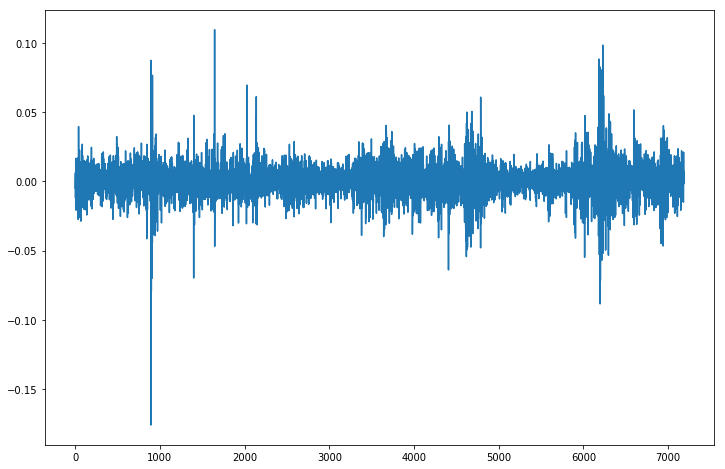

In [6]:
plt.figure(figsize=(12,8))
plt.plot(data.ftse100)
plt.show()

Возможные типы разладок:
* Увеличение/уменьшение среднего
* Увеличение/уменьшение дисперсии
  
Здесь хорошо наблюдается первый тип разладок.

Возьмем начальный отрезок длины 800.

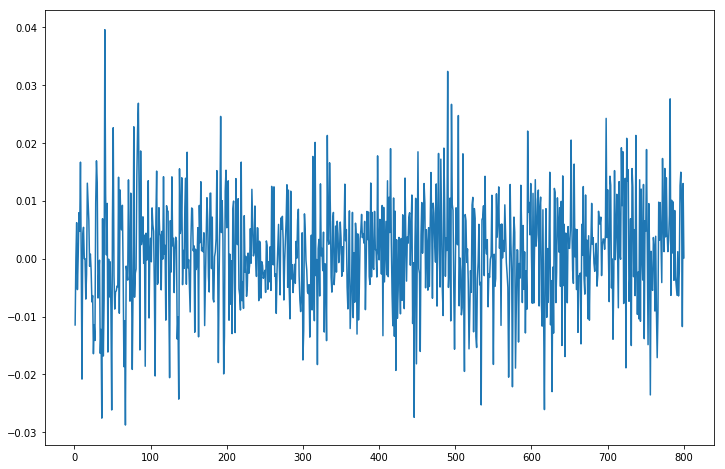

In [7]:
plt.figure(figsize=(12,8))
plt.plot(data.ftse100[:800])
plt.show()

Похоже, что это нормальное распределение. Оценим его параметры.

In [8]:
value = np.array(data.ftse100[:800])

a = np.mean(value)
sigma = np.mean(value ** 2) - (a ** 2)

In [9]:
print('%.5f' % a)

0.00092


Тогда логичным кажется считать разладкой увеличение/уменьшение среднего в 8 и более раз (под уменьшением понимается уход в отрицательные числа).

Сначала будем искать увеличение среднего. Ожидаем найти 3 разладки:
* 897
* 1646
* 6228
  
где цифры - номера строчек в исходной таблице. На графике ftse100 есть и другие резкие скачки вверх, но, кажется, их не стоит считать разладками.

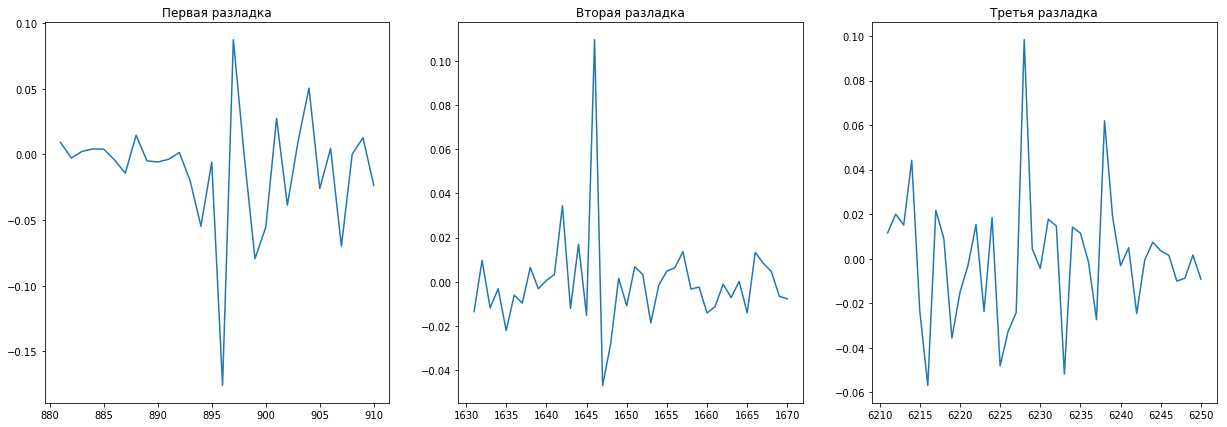

In [10]:
plt.figure(figsize=(21,7))

gs = gridspec.GridSpec(1, 3)

ax1 = plt.subplot(gs[0, 0])
ax2 = plt.subplot(gs[0, 1])
ax3 = plt.subplot(gs[0, 2])

ax1.plot(data.ftse100[880:910])
ax1.set_title('Первая разладка')

ax2.plot(data.ftse100[1630:1670])
ax2.set_title('Вторая разладка')

ax3.plot(data.ftse100[6210:6250])
ax3.set_title('Третья разладка')

plt.show()

Найдем первую разладку.

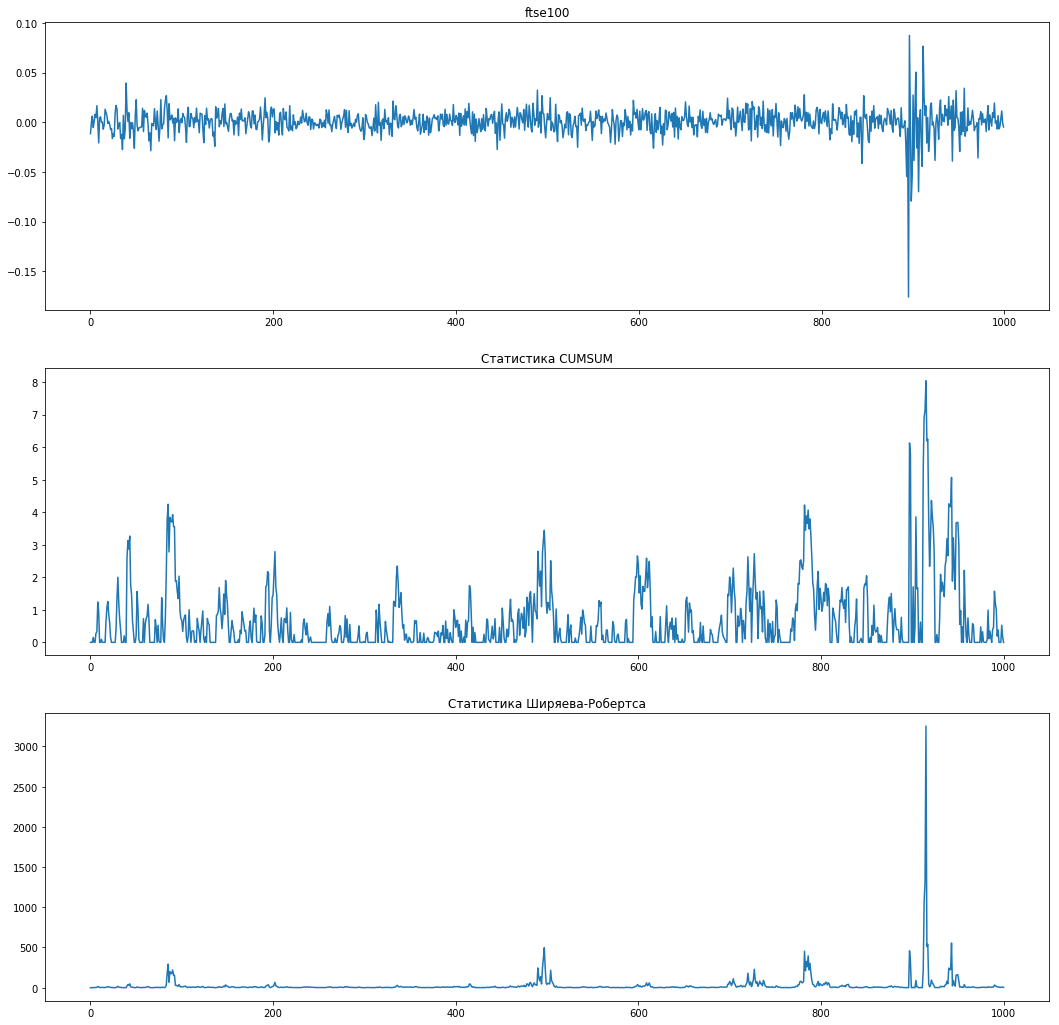

In [11]:
plt.figure(figsize=(18,18))

gs = gridspec.GridSpec(3, 1)

ax1 = plt.subplot(gs[0, :])
ax2 = plt.subplot(gs[1, :])
ax3 = plt.subplot(gs[2, :])

ax1.plot(data.ftse100[:1000].tolist())
ax1.set_title('ftse100')

ax2.plot(cumsum(data.ftse100[:1000].tolist(), a, 8*a, sigma))
ax2.set_title('Статистика CUMSUM')

ax3.plot(shr(data.ftse100[:1000].tolist(), a, 8*a, sigma))
ax3.set_title('Статистика Ширяева-Робертса')

plt.show()

In [12]:
print('Момент подачи сигнала статистикой CUMSUM:', 
      np.argmax(cumsum(data.ftse100[:1000].tolist(), a, 8*a, sigma)),
      '\nМомент подачи сигнала статистикой Ширяева-Робертса:',
      np.argmax(shr(data.ftse100[:1000].tolist(), a, 8*a, sigma)))

Момент подачи сигнала статистикой CUMSUM: 915 
Момент подачи сигнала статистикой Ширяева-Робертса: 915


Итак, ложных тревог не было, а задержка составила 18 дней.

Так как мы нашли разладку, то теперь оценку статистик нужно производить заново.

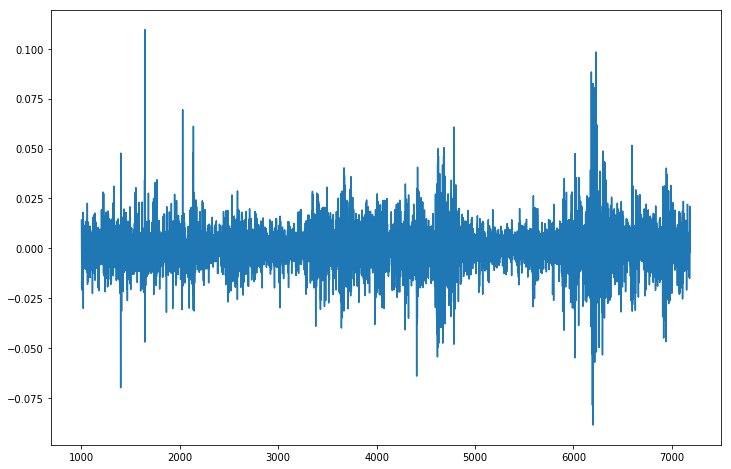

In [13]:
plt.figure(figsize=(12,8))
plt.plot(data.ftse100[1000:])
plt.show()

Возьмем начальный отрезок длины 300.

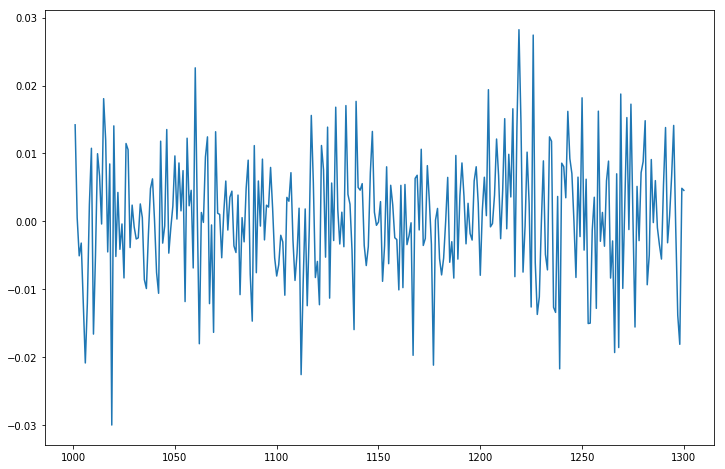

In [14]:
plt.figure(figsize=(12,8))
plt.plot(data.ftse100[1000:1300])
plt.show()

Похоже на нормальное распределение. Оценим его параметры.

In [15]:
value = np.array(data.ftse100[1000:1300])

a = np.mean(value)
sigma = np.mean(value ** 2) - (a ** 2)

In [16]:
print('%.5f' % a)

0.00058


Попробуем найти вторую разладку.

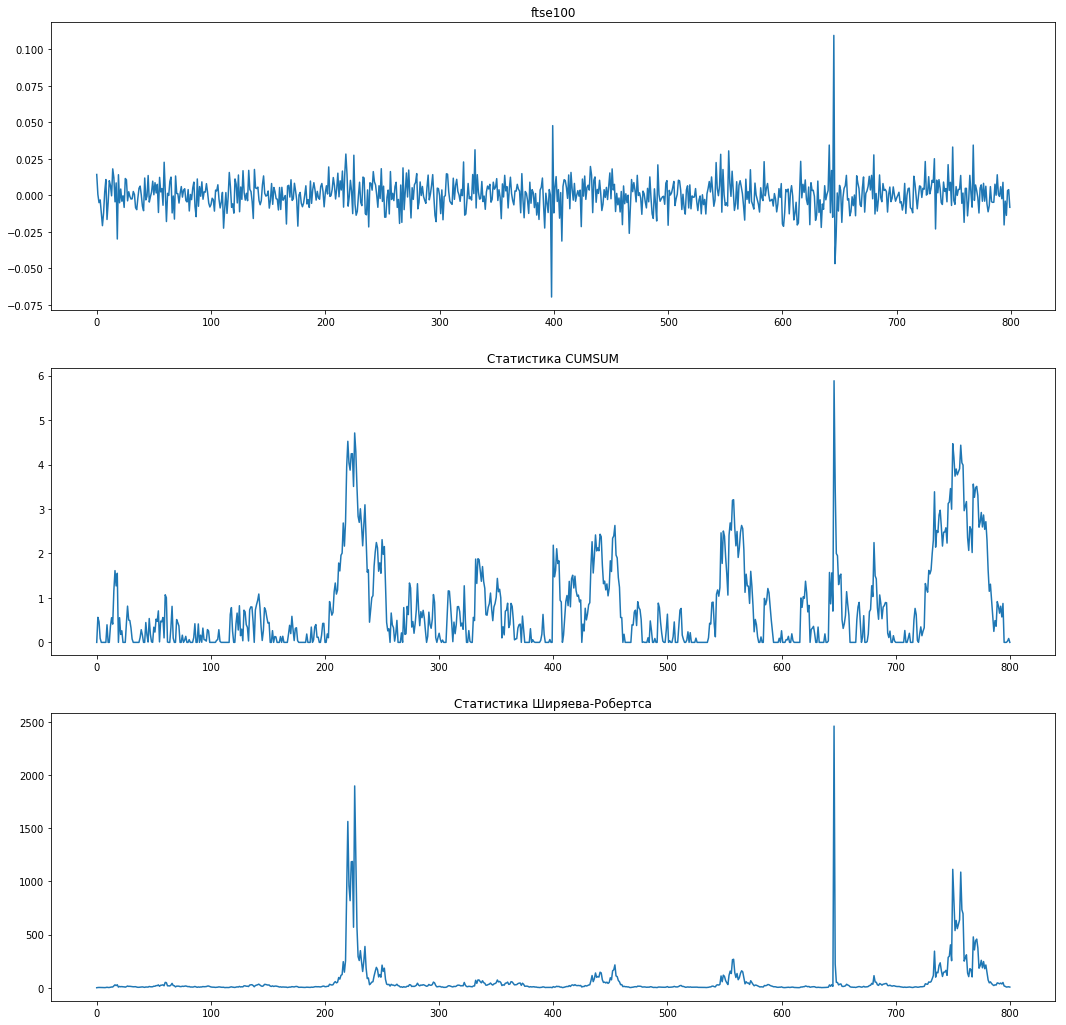

In [17]:
plt.figure(figsize=(18,18))

gs = gridspec.GridSpec(3, 1)

ax1 = plt.subplot(gs[0, :])
ax2 = plt.subplot(gs[1, :])
ax3 = plt.subplot(gs[2, :])

ax1.plot(data.ftse100[1000:1800].tolist())
ax1.set_title('ftse100')

ax2.plot(cumsum(data.ftse100[1000:1800].tolist(), a, 8*a, sigma))
ax2.set_title('Статистика CUMSUM')

ax3.plot(shr(data.ftse100[1000:1800].tolist(), a, 8*a, sigma))
ax3.set_title('Статистика Ширяева-Робертса')

plt.show()

Во втором случае у нас появилась ложная тревога: в диапазоне [1200-1300] не было ничего аномального.

In [18]:
print('Момент подачи сигнала статистикой CUMSUM:', 
      1000 + np.argmax(cumsum(data.ftse100[1000:1800].tolist(), a, 8*a, sigma)),
      '\nМомент подачи сигнала статистикой Ширяева-Робертса:',
      1000 + np.argmax(shr(data.ftse100[1000:1800].tolist(), a, 8*a, sigma)))

Момент подачи сигнала статистикой CUMSUM: 1646 
Момент подачи сигнала статистикой Ширяева-Робертса: 1646


Зато во втором случае нулевая задержка сигнала.

Вновь оценим статистики.

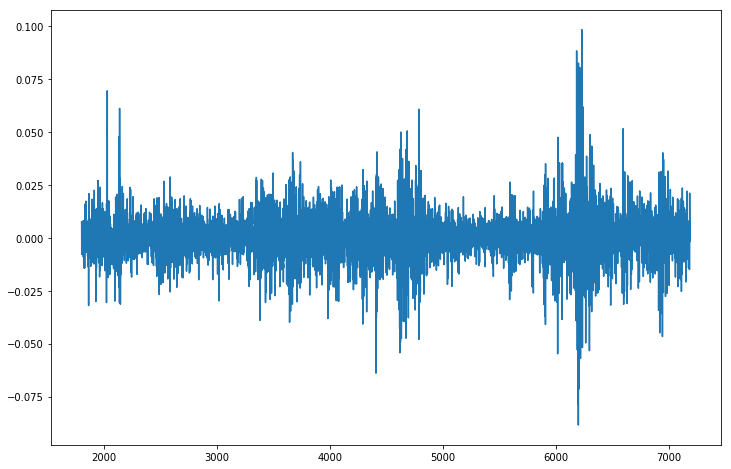

In [19]:
plt.figure(figsize=(12,8))
plt.plot(data.ftse100[1800:])
plt.show()

Возьмем начальный отрезок длины 1000.

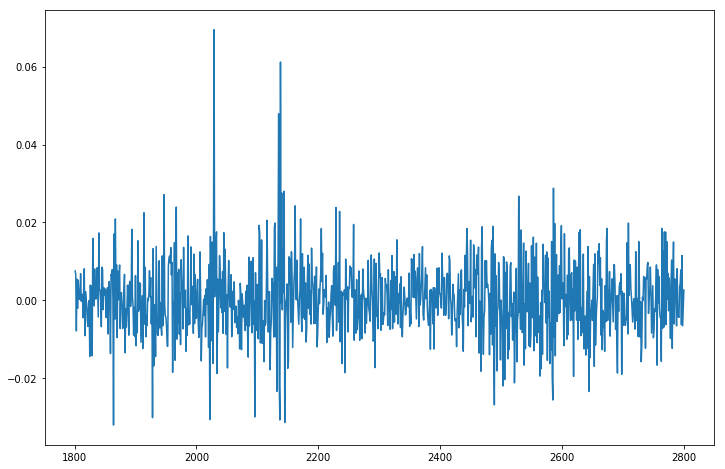

In [20]:
plt.figure(figsize=(12,8))
plt.plot(data.ftse100[1800:2800])
plt.show()

Не совсем нормальное распределение, но все равно близко к нему. Оценим параметры.

In [21]:
value = np.array(data.ftse100[1800:2800])

a = np.mean(value)
sigma = np.mean(value ** 2) - (a ** 2)

In [22]:
print('%.5f' % a)

0.00032


Попробуем найти третью разладку.

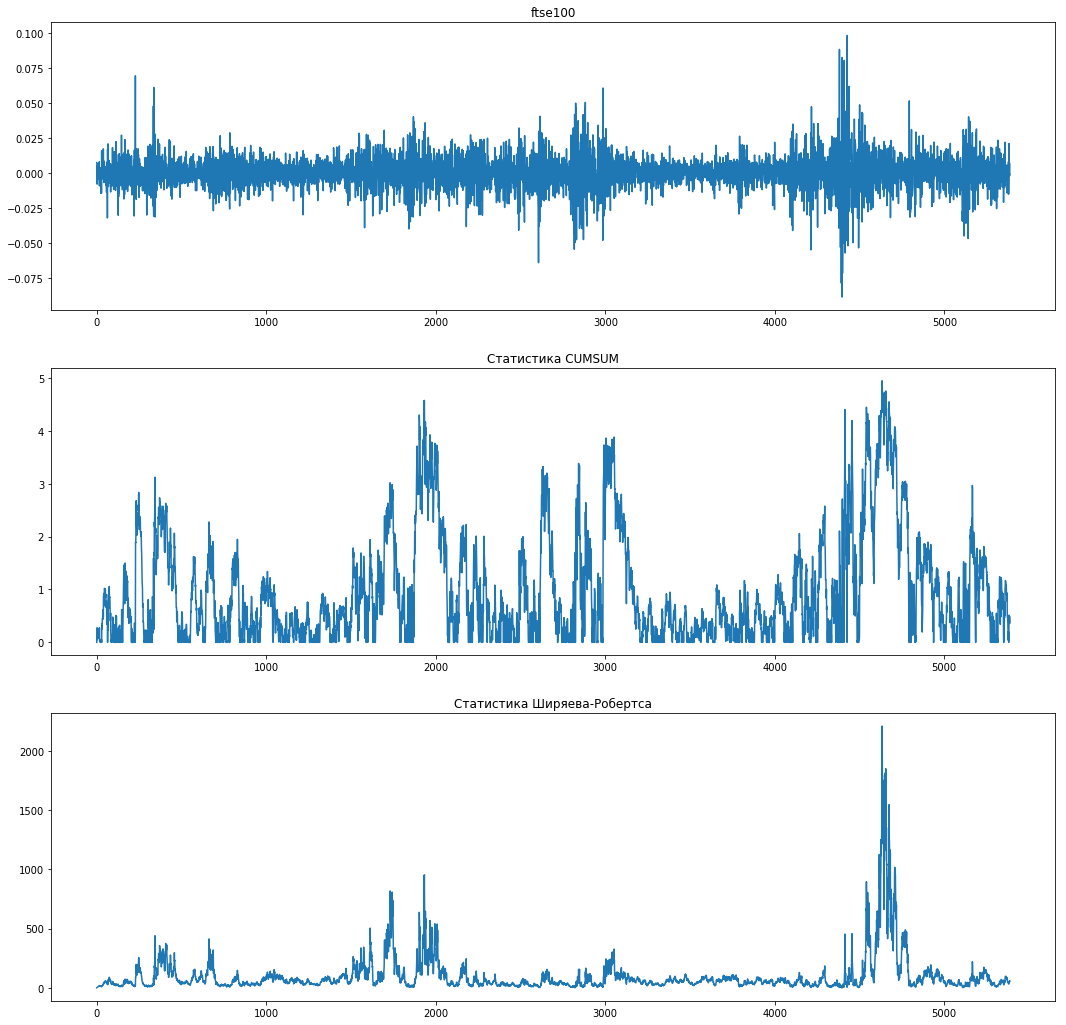

In [23]:
plt.figure(figsize=(18,18))

gs = gridspec.GridSpec(3, 1)

ax1 = plt.subplot(gs[0, :])
ax2 = plt.subplot(gs[1, :])
ax3 = plt.subplot(gs[2, :])

ax1.plot(data.ftse100[1800:].tolist())
ax1.set_title('ftse100')

ax2.plot(cumsum(data.ftse100[1800:].tolist(), a, 8*a, sigma))
ax2.set_title('Статистика CUMSUM')

ax3.plot(shr(data.ftse100[1800:].tolist(), a, 8*a, sigma))
ax3.set_title('Статистика Ширяева-Робертса')

plt.show()

Статистика CUMSUM находить ложные разладки, а статистика Ширяева-Робертса - нет. Поэтому можно считать, что ложных тревог не было.

In [24]:
first = np.argmax(cumsum(data.ftse100[1800:].tolist(), a, 8*a, sigma))
second = np.argmax(shr(data.ftse100[1800:].tolist(), a, 8*a, sigma))

realfirst = np.argmin(data.ftse100[first - 100:first])
realsecond = np.argmin(data.ftse100[second - 100:second])

print('Момент подачи сигнала статистикой CUMSUM:', 
      1800 + realfirst,
      '\nМомент подачи сигнала статистикой Ширяева-Робертса:',
      1800 + realsecond)

Момент подачи сигнала статистикой CUMSUM: 6418 
Момент подачи сигнала статистикой Ширяева-Робертса: 6418


Задержка в подаче сигнала: 190 дней.

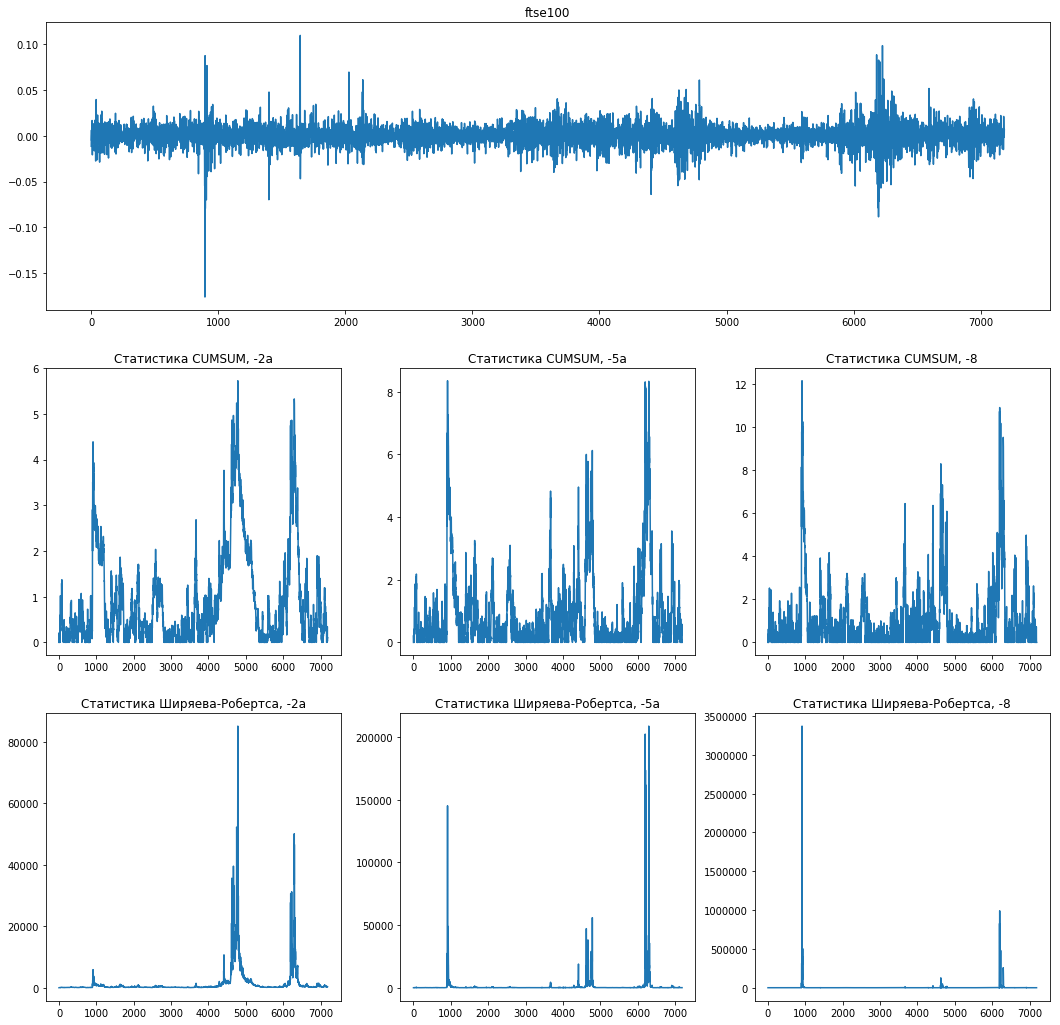

In [25]:
plt.figure(figsize=(18,18))

gs = gridspec.GridSpec(3, 3)

ax0 = plt.subplot(gs[0, :])
ax1 = plt.subplot(gs[1, 0])
ax2 = plt.subplot(gs[1, 1])
ax3 = plt.subplot(gs[1, 2])
ax4 = plt.subplot(gs[2, 0])
ax5 = plt.subplot(gs[2, 1])
ax6 = plt.subplot(gs[2, 2])

ax0.plot(data.ftse100.tolist())
ax0.set_title('ftse100')

ax1.plot(cumsum(data.ftse100.tolist(), a, -2*a, sigma))
ax1.set_title('Статистика CUMSUM, -2a')

ax2.plot(cumsum(data.ftse100.tolist(), a, -5*a, sigma))
ax2.set_title('Статистика CUMSUM, -5a')

ax3.plot(cumsum(data.ftse100.tolist(), a, -8*a, sigma))
ax3.set_title('Статистика CUMSUM, -8')

ax4.plot(shr(data.ftse100.tolist(), a, -2*a, sigma))
ax4.set_title('Статистика Ширяева-Робертса, -2a')

ax5.plot(shr(data.ftse100.tolist(), a, -5*a, sigma))
ax5.set_title('Статистика Ширяева-Робертса, -5a')

ax6.plot(shr(data.ftse100.tolist(), a, -8*a, sigma))
ax6.set_title('Статистика Ширяева-Робертса, -8')

plt.show()

## Traffic

In [26]:
data = pd.read_csv('internet-traffic.csv', sep=';',
                   names=['time', 'traffic'], skiprows=[0])

In [27]:
data.head()

,time,traffic
0,2004-11-19 09:30:00,64554.479
1,2004-11-19 10:30:00,71138.749
2,2004-11-19 11:30:00,77253.266
3,2004-11-19 12:30:00,77340.780
4,2004-11-19 13:30:00,79860.759


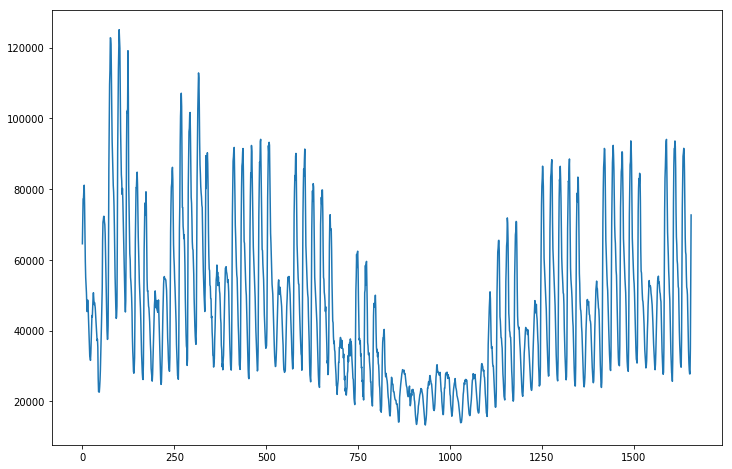

In [28]:
plt.figure(figsize=(12,8))

plt.plot(data.traffic)

plt.show()